<img align="right" src="https://ds-cs-images.s3.ap-northeast-2.amazonaws.com/Codestates_Fulllogo_Color.png" width=100>

## *DATA SCIENCE / SECTION 2 / SPRINT 2 / NOTE 4*

---
# 모델선택(Model Selection)

- 모델선택을 위한 **교차검증** 방법을 이해하고 활용할 수 있다.
- **하이퍼파라미터**를 최적화하여 모델의 성능을 향상시킬 수 있다.

### Warm up

다음 동영상을 시청해 봅시다.

- [StatQuest: Cross-Validation](https://youtu.be/fSytzGwwBVw)
    - 교차검증 사용 이유는 무엇일까요? (두 가지를 찾아 보세요)


주요 라이브러리
- category_encoders
- matplotlib
- numpy
- pandas
- pandas-profiling
- scikit-learn
- scipy.stats

---

#### 이번 강의는 Ames Housing dataset 을 이용해서 진행해 보겠습니다.

In [1]:
import pandas as pd
# Import house prices data
train = pd.read_csv('https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/house-prices/house_prices_train.csv')

##### 훈련 데이터에서 마지막에 사용할 테스트세트를 따로 구분해 놓겠습니다.

In [2]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(train, test_size=260, random_state=2)

In [3]:
train.shape, test.shape

((1200, 81), (260, 81))

In [4]:
from pandas_profiling import ProfileReport
profile = ProfileReport(train, minimal=True).to_notebook_iframe()

Summarize dataset:   0%|          | 0/91 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
import numpy as np
import pandas as pd

In [6]:
# 훈련/테스트 세트 모두 전처리 하기위한 함수입니다.
def clean(df):
    df = df.copy()
    
    ## 타겟변수의 이상치(outlier)를 제거합니다.
    df['SalePrice'] = df[df['SalePrice'] < np.percentile(df['SalePrice'], 99)]['SalePrice']
    
    ## 타겟변수가 결측치인 샘플을 제거 합니다.
    df.dropna(subset=['SalePrice'], inplace=True)

    ## id 변수를 제거합니다.
    df = df.drop("Id", axis = 1)

    ## 변수를 합치고 새로운 변수를 생성합니다.(참고, https://www.kaggle.com/yadavsarthak/house-prices-advanced-regression-techniques/you-got-this-feature-engineering-and-lasso)
    df['All_Flr_SF'] = df['1stFlrSF'] + df['2ndFlrSF']
    df['All_Liv_SF'] = df['All_Flr_SF'] + df['LowQualFinSF'] + df['GrLivArea']
    df = df.drop(['1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea'], axis=1)

    ## 변수의 이상치를 제거합니다.
    df['All_Flr_SF'] = df[df['All_Flr_SF'] < np.percentile(df['All_Flr_SF'], 99.5)]['All_Flr_SF']
    df['All_Liv_SF'] = df[df['All_Liv_SF'] < np.percentile(df['All_Liv_SF'], 99.5)]['All_Liv_SF']
    
    ## 결측값을 파이프라인에서 평균/중간값으로 처리하면 안되는 몇몇 특성이 있어 미리 처리하겠습니다.
    ## (https://www.kaggle.com/juliensiems/cleaning-new-features-gps-coordinates-included)
    
    ## 이외 특성들의 결측값은 파이프라인에서 처리합니다.
    
    # Alley : NA == "no alley access"
    df.loc[:, "Alley"] = df.loc[:, "Alley"].fillna("None")
    
    # BedroomAbvGr : NA ~ 0
    df.loc[:, "BedroomAbvGr"] = df.loc[:, "BedroomAbvGr"].fillna(0)
    
    # BsmtQual etc : NA == "no basement"
    df.loc[:, "BsmtQual"] = df.loc[:, "BsmtQual"].fillna("No")
    df.loc[:, "BsmtCond"] = df.loc[:, "BsmtCond"].fillna("No")
    df.loc[:, "BsmtExposure"] = df.loc[:, "BsmtExposure"].fillna("No")
    df.loc[:, "BsmtFinType1"] = df.loc[:, "BsmtFinType1"].fillna("No")
    df.loc[:, "BsmtFinType2"] = df.loc[:, "BsmtFinType2"].fillna("No")
    df.loc[:, "BsmtFullBath"] = df.loc[:, "BsmtFullBath"].fillna(0)
    df.loc[:, "BsmtHalfBath"] = df.loc[:, "BsmtHalfBath"].fillna(0)
    df.loc[:, "BsmtUnfSF"] = df.loc[:, "BsmtUnfSF"].fillna(0)
    
    # CentralAir : NA ~ No
    df.loc[:, "CentralAir"] = df.loc[:, "CentralAir"].fillna("N")
    
    # Condition : NA ~ Normal
    df.loc[:, "Condition1"] = df.loc[:, "Condition1"].fillna("Norm")
    df.loc[:, "Condition2"] = df.loc[:, "Condition2"].fillna("Norm")
    
    # EnclosedPorch : NA ~ no enclosed porch
    df.loc[:, "EnclosedPorch"] = df.loc[:, "EnclosedPorch"].fillna(0)
    
    # External stuff : NA ~ average
    df.loc[:, "ExterCond"] = df.loc[:, "ExterCond"].fillna("TA")
    df.loc[:, "ExterQual"] = df.loc[:, "ExterQual"].fillna("TA")
    
    # Fence : NA == "no fence"
    df.loc[:, "Fence"] = df.loc[:, "Fence"].fillna("No")
    
    # FireplaceQu : NA == "no fireplace"
    df.loc[:, "FireplaceQu"] = df.loc[:, "FireplaceQu"].fillna("No")
    df.loc[:, "Fireplaces"] = df.loc[:, "Fireplaces"].fillna(0)
    
    # Functional : NA == "typical"
    df.loc[:, "Functional"] = df.loc[:, "Functional"].fillna("Typ")
    
    # GarageType etc : NA == "no garage"
    df.loc[:, "GarageType"] = df.loc[:, "GarageType"].fillna("No")
    df.loc[:, "GarageFinish"] = df.loc[:, "GarageFinish"].fillna("No")
    df.loc[:, "GarageQual"] = df.loc[:, "GarageQual"].fillna("No")
    df.loc[:, "GarageCond"] = df.loc[:, "GarageCond"].fillna("No")
    df.loc[:, "GarageArea"] = df.loc[:, "GarageArea"].fillna(0)
    df.loc[:, "GarageCars"] = df.loc[:, "GarageCars"].fillna(0)
    
    # HalfBath : NA ~ no half baths above grade
    df.loc[:, "HalfBath"] = df.loc[:, "HalfBath"].fillna(0)
    
    # HeatingQC : NA ~ typical
    df.loc[:, "HeatingQC"] = df.loc[:, "HeatingQC"].fillna("TA")
    
    # KitchenAbvGr : NA ~ 0
    df.loc[:, "KitchenAbvGr"] = df.loc[:, "KitchenAbvGr"].fillna(0)
    
    # KitchenQual : NA ~ typical
    df.loc[:, "KitchenQual"] = df.loc[:, "KitchenQual"].fillna("TA")
    
    # LotFrontage : NA ~ no lot frontage
    df.loc[:, "LotFrontage"] = df.loc[:, "LotFrontage"].fillna(0)
    
    # LotShape : NA ~ regular
    df.loc[:, "LotShape"] = df.loc[:, "LotShape"].fillna("Reg")
    
    # MasVnrType : NA ~ no veneer
    df.loc[:, "MasVnrType"] = df.loc[:, "MasVnrType"].fillna("None")
    df.loc[:, "MasVnrArea"] = df.loc[:, "MasVnrArea"].fillna(0)
    
    # MiscFeature : NA == "no misc feature"
    df.loc[:, "MiscFeature"] = df.loc[:, "MiscFeature"].fillna("No")
    df.loc[:, "MiscVal"] = df.loc[:, "MiscVal"].fillna(0)
    
    # OpenPorchSF : NA ~ no open porch
    df.loc[:, "OpenPorchSF"] = df.loc[:, "OpenPorchSF"].fillna(0)
    
    # PavedDrive : NA ~ not paved
    df.loc[:, "PavedDrive"] = df.loc[:, "PavedDrive"].fillna("N")
    
    # PoolQC : NA == "no pool"
    df.loc[:, "PoolQC"] = df.loc[:, "PoolQC"].fillna("No")
    df.loc[:, "PoolArea"] = df.loc[:, "PoolArea"].fillna(0)
    
    # SaleCondition : NA ~ normal sale
    df.loc[:, "SaleCondition"] = df.loc[:, "SaleCondition"].fillna("Normal")
    
    # ScreenPorch : NA ~ no screen porch
    df.loc[:, "ScreenPorch"] = df.loc[:, "ScreenPorch"].fillna(0)
    
    # TotRmsAbvGrd : NA ~ 0
    df.loc[:, "TotRmsAbvGrd"] = df.loc[:, "TotRmsAbvGrd"].fillna(0)
    
    # Utilities : NA ~ all public utilities
    df.loc[:, "Utilities"] = df.loc[:, "Utilities"].fillna("AllPub")
    
    # WoodDeckSF : NA ~ no wood deck
    df.loc[:, "WoodDeckSF"] = df.loc[:, "WoodDeckSF"].fillna(0)
    df[df['Neighborhood'] == 'Greens']
    

    return df

In [7]:
train = clean(train)
test = clean(test)

In [8]:
train.shape, test.shape

((1188, 78), (257, 78))

## 교차검증(Cross-validation)

지금까지는 데이터를 **훈련/검증/테스트 세트**로 나누어 학습을 진행해 왔습니다.(이 방법은 **hold-out 교차검증** 이라고 합니다.) 이 방법은 어떤 문제점을 가지고 있을까요?

- 학습에 사용가능한 데이터가 충분하다면 문제가 없겠지만, 훈련세트의 크기가 모델학습에 충분하지 않을 경우 문제가 될 수 있습니다. 
- 검증세트 크기가 충분히 크지 않다면 예측 성능에 대한 추정이 부정확할 것입니다.

이것 외에 다른 문제점도 있습니다. 여러분은 앞으로 수많은 기계학습 알고리즘을 사용할 것인데 모든 문제에 적용가능한 최고의 학습 모델은 없다는 것을 알고 계시지요?

- **우리 문제를 풀기위해 어떤 학습 모델을 사용해야 할 것인지?**
- **어떤 하이퍼파라미터를 사용할 것인지?**

이러한 문제가 **모델선택(Model selection)** 문제입니다.

이렇게 데이터의 크기에 대한 문제, 모델선택에 대한 문제를 해결하기 위해 사용하는 방법 중 한 가지가 **교차검증**입니다.

##### 참고:교차검증은 **시계열(time series)** 데이터에는 적합하지 않습니다


<img src="https://sebastianraschka.com/images/blog/2016/model-evaluation-selection-part3/kfold.png" width="700">

### 교차검증을 사용해 보겠습니다.

교차검증을 하기 위해서는 데이터를 k개로 등분하여야 하는데 이를 k-fold cross-validation(CV) 라고 합니다. k개의 집합에서 k-1 개의 부분집합을 훈련에 사용하고 나머지 부분집합을 테스트 데이터로 검증하게 됩니다.

예를들어, 데이터를 3등분으로 나누고 검증(1/3)과 훈련세트(2/3)를 총 세번 바꾸어가며 검증하는 것은 3-fold CV 입니다.

10-fold CV의 경우 검증을 총 10번을 하겠지요!


사이킷런에 [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn-model-selection-cross-val-score) 를 사용하면 교차검증을 쉽게 적용할 수 있습니다.


cross_val_score 는 어떻게 사용할까요?

- [3.1.1. Computing cross-validated metrics
](https://scikit-learn.org/stable/modules/cross_validation.html#computing-cross-validated-metrics)

학습된 모델, 학습데이터, 타겟데이터, k 값(default = 5)을 준비하면 쉽게 사용할 수 있습니다.

#### 선형모델을 만들어 교차검증을 수행해 보겠습니다.

In [9]:
from category_encoders import OneHotEncoder
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.impute import SimpleImputer
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

# (참고) warning 제거를 위한 코드
np.seterr(divide='ignore', invalid='ignore')

target = 'SalePrice'
features = train.columns.drop([target])
X_train = train[features]
y_train = train[target]

X_test = test[features]
y_test = test[target]


pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(), 
    SelectKBest(f_regression, k=20),
    Ridge(alpha=1.0)
)

# 3-fold 교차검증을 수행합니다.
k = 3
scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE ({k} folds):', -scores)

MAE (3 folds): [19912.3716215  23214.74205495 18656.29713167]


In [10]:
-scores.mean()

20594.470269371817

In [11]:
scores.std()

1922.4635156881875

### 랜덤포레스트에 적용해 보겠습니다.

In [12]:
from category_encoders import TargetEncoder
from sklearn.ensemble import RandomForestRegressor

pipe = make_pipeline(
    # TargetEncoder: 범주형 변수 인코더로, 타겟값을 특성의 범주별로 평균내어 그 값으로 인코딩
    TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(max_depth = 10, n_jobs=-1, random_state=2)
)

k = 3

scores = cross_val_score(pipe, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [16289.34502313 19492.01218055 15273.23000751]


In [13]:
-scores.mean()

17018.19573706592

In [14]:
scores.std()

1797.7668143704157

#### (참고) TargetEncoder 인코딩을 확인해 보겠습니다.

In [15]:
X_train.describe(exclude='number')

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
count,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188,...,1188,1188,1188,1188,1188,1188,1188,1188,1188,1188
unique,5,2,3,4,4,2,5,3,25,9,...,7,4,6,6,3,3,5,5,9,6
top,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,No,No,No,WD,Normal
freq,936,1184,1112,759,1068,1187,856,1122,183,1024,...,709,508,1068,1080,1084,1184,961,1140,1036,986


In [16]:
enc = TargetEncoder(min_samples_leaf=1, smoothing=1000) 
enc.fit_transform(X_train,y_train)['LotShape'].value_counts()

166368.017847    759
190133.621187    391
194093.059489     28
196089.739213     10
Name: LotShape, dtype: int64

In [17]:
X_train['LotShape'].value_counts()

Reg    759
IR1    391
IR2     28
IR3     10
Name: LotShape, dtype: int64

In [18]:
y_train[X_train[X_train.LotShape == 'Reg'].index].sum() / 759

161871.9486166008

#### 랜덤포레스트 학습시 `max_depth`를 10으로 주었습니다.
그리고 다른 하이퍼파라미터는 기본값으로 사용하였는데요.

이 값이 적정할까요? 
어떻게 하이퍼파라미터를 조절할 수 있을까요?

## 하이퍼파라미터 튜닝

#### 사이킷런을 사용하여 하이퍼파라미터를 최적화 할 수 있습니다

머신러닝 모델을 만들때 중요한 이슈는 최적화(optimization)와 일반화(generalization) 입니다. 

- **최적화**는 훈련 데이터로 더 좋은 성능을 얻기 위해 모델을 조정하는 과정이며, 
- **일반화**는 학습된 모델이 처음 본 데이터에서 얼마나 좋은 성능을 내는지를 이야기 합니다. 

모델의 복잡도를 높이는 과정에서 훈련/검증 세트의 손실이 함께 감소하는 시점은 과소적합(underfitting) 되었다고 합니다.

이 때는 모델이 더 학습 될 여지가 있습니다. 하지만 어느 시점부터 훈련데이터의 손실은 계속 감소하는데 검증데이터의 손실은 증가하는 때가 있습니다. 이때 우리는 과적합(overfitting) 되었다고 합니다.

이상적인 모델은 과소적합과 과적합 사이에 존재합니다.

<img src="https://www.researchgate.net/profile/Hayder_Al-Behadili/publication/325999203/figure/fig4/AS:641844216074241@1530038994324/Overfitting-and-underfitting-effect-on-error.png" width="600" />

### 검증곡선(validation curve)를 그려 봅시다.
**검증곡선**은 훈련/검증데이터에 대해 
    - y축: 스코어 
    - x축: 하이퍼파라미터
로 그린 그래프 입니다.

(참고로 **훈련곡선**(learning curve)이라는 용어는 x축이 훈련데이터 수(# of training samples)에 대해 그린 것 으로 검증곡선과 혼동하지 마세요.)

그럼 이제 검증곡선을 그려보고 학습이 최적화된 지점을 찾아 봅시다.

Scikit-learn, [validation curves](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.validation_curve.html#sklearn-model-selection-validation-curve)
를 사용하면 다양한 하이퍼파라미터 값에 대해 훈련/검증 스코어 값의 변화를 확인할 수 있습니다. 이것은 다음에 배울 grid search에서 한 가지 파라미터를 사용하는 것과 유사합니다. 


사실 하나의 파라미터만 가지고 검증곡선을 그리는 것이 현실적으로 아주 유용하지는 않습니다. 현실에서는 더 많은 파라미터의 변화에 대한 결과를 보는 것이 중요하지요.

한 번 결정트리에서 과적합을 막아줄 때 제한하는 `max_depth`를 변화시키며 검증곡선을 그려봅시다.

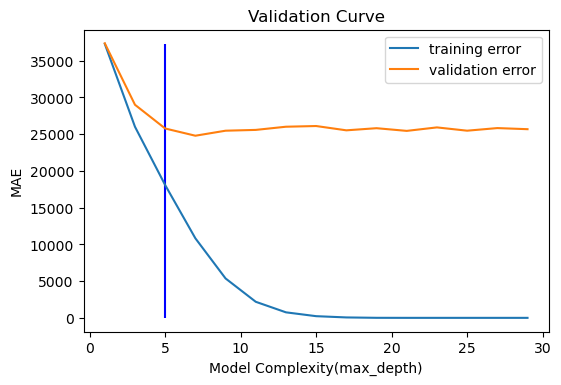

In [19]:
import matplotlib.pyplot as plt
from category_encoders import OrdinalEncoder
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

pipe = make_pipeline(
    OrdinalEncoder(), 
    SimpleImputer(), 
    DecisionTreeRegressor()
)

depth = range(1, 30, 2)
ts, vs = validation_curve(
    pipe, X_train, y_train
    , param_name='decisiontreeregressor__max_depth'
    , param_range=depth, scoring='neg_mean_absolute_error'
    , cv=3
    , n_jobs=-1
)

train_scores_mean = np.mean(-ts, axis=1)
validation_scores_mean = np.mean(-vs, axis=1)

fig, ax = plt.subplots()

# 훈련세트 검증곡선
ax.plot(depth, train_scores_mean, label='training error')

# 검증세트 검증곡선
ax.plot(depth, validation_scores_mean, label='validation error')

# 이상적인 max_depth
ax.vlines(5,0, train_scores_mean.max(), color='blue')

# 그래프 셋팅
ax.set(title='Validation Curve'
      , xlabel='Model Complexity(max_depth)', ylabel='MAE')
ax.legend()
fig.dpi = 100

이대로 트리의 깊이를 정해야 한다면 max_depth = 5 부근에서 설정해 주어야 과적합을 막고 일반화 성능을 지킬 것 같습니다

### Randomized Search CV

이제 여러 하이퍼파라미터의 최적값을 찾기 위해 **[RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)** 를 사용해 봅시다.

하이퍼파라미터는 모델 훈련중에 학습이 되지 않는 파라미터입니다. 그래서 사용자가 직접 정해주어야 합니다.

현실적으로 하이퍼파라미터를 수작업으로 정해주는 것은 어렵습니다. 최적의 하이퍼파라미터 조합을 찾아주는 도구를 사용해야 합니다.
사이킷런에 하이퍼파라미터 튜닝을 도와주는 좋은 툴이 두 가지 있습니다.

- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV): 검증하고 싶은 하이퍼파라미터들의 수치를 정해주고 그 조합을 모두 검증합니다.

- [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html): 검증하려는 하이퍼파라미터들의 값 범위를 지정해주면 무작위로 값을 지정해 그 조합을 모두 검증합니다.

<img src="https://www.researchgate.net/profile/Amirhessam_Tahmassebi/publication/333073682/figure/fig4/AS:759165278490624@1558010515055/An-illustration-of-grid-search-and-random-search-layouts.ppm" width="600" />

### Ridge 회귀모델의 하이퍼파라미터를 튜닝해보겠습니다.

In [20]:
from sklearn.model_selection import RandomizedSearchCV

pipe = make_pipeline(
    OneHotEncoder(use_cat_names=True)
    , SimpleImputer()
    , StandardScaler()
    , SelectKBest(f_regression)
    , Ridge()
)

# 튜닝할 하이퍼파라미터의 범위를 지정해 주는 부분
dists = {
    'simpleimputer__strategy': ['mean', 'median'], 
    'selectkbest__k': range(1, len(X_train.columns)+1), 
    'ridge__alpha': [0.1, 1, 10], 
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3,
    scoring='neg_mean_absolute_error',
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [21]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)


최적 하이퍼파라미터:  {'simpleimputer__strategy': 'median', 'selectkbest__k': 59, 'ridge__alpha': 10}
MAE:  18516.88451584581


RandomSearchCV는 n_iter(=50) * 3 교차검증 = 150 tasks를 수행했습니다

하지만 GridSearchCV를 사용해 이 범위를 검색하려면 얼마나 많은 태스크가 필요할까요?
-  2 imputation * n cols * 3 alphas * 3 cv

In [22]:
2 * len(X_train.columns) * 3 * 3

1386

#### 각 하이퍼파라미터 조합으로 만들어진 모델들을 순위별로 나열해 봅니다.

In [23]:
# rank_test_score: 테스트 순위
# mean_score_time: 예측에 걸리는 시간
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,30,5,13,46,7,4,24,33,12,8,...,16,49,32,23,18,35,36,27,38,1
mean_fit_time,1.60914,1.76922,1.60596,1.56645,1.74447,1.78236,1.60664,1.57272,1.64691,1.79202,...,1.57473,0.965172,1.54972,1.65417,1.61404,1.61661,1.5838,1.62641,1.58775,1.83879
std_fit_time,0.00247959,0.00316318,0.00742196,0.00383376,0.0122621,0.0048717,0.021808,0.0205971,0.0183591,0.00780811,...,0.0223435,0.00639667,0.00650621,0.00493833,0.00824345,0.0034403,0.00610936,0.0080693,0.0144328,0.00326116
mean_score_time,0.56316,0.514543,0.539656,0.549511,0.505976,0.519527,0.569698,0.585354,0.541516,0.614539,...,0.573455,0.295868,0.617335,0.54619,0.552464,0.578076,0.569794,0.572668,0.562482,0.661764
std_score_time,0.0466234,0.0509787,0.0481442,0.0388337,0.0407535,0.0372524,0.0448721,0.0508005,0.04496,0.0662217,...,0.0582601,0.0241842,0.0188039,0.0516519,0.0506241,0.0553787,0.0469497,0.0519582,0.045827,0.0772338
param_simpleimputer__strategy,median,mean,mean,median,median,mean,median,mean,mean,mean,...,mean,mean,mean,mean,median,median,mean,mean,mean,median
param_selectkbest__k,59,54,66,57,72,61,76,54,73,63,...,19,18,12,15,9,8,5,2,2,1
param_ridge__alpha,10,10,10,1,1,1,1,0.1,0.1,0.1,...,1,10,0.1,0.1,10,1,10,10,0.1,0.1
params,"{'simpleimputer__strategy': 'median', 'selectk...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'median', 'selectk...","{'simpleimputer__strategy': 'median', 'selectk...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'median', 'selectk...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...",...,"{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'median', 'selectk...","{'simpleimputer__strategy': 'median', 'selectk...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'mean', 'selectkbe...","{'simpleimputer__strategy': 'median', 'selectk..."
split0_test_score,-18799.3,-18773.3,-18635.9,-18816.1,-18226.2,-18864.3,-18150.5,-18813.8,-18242.4,-18560.1,...,-19919.1,-20429.5,-21282.4,-21270.6,-22309.7,-22497.6,-23656.2,-25327.1,-25371.7,-30372.9
split1_test_score,-19811.4,-20016.8,-20217.5,-19913.8,-20216.5,-19923,-20153.2,-20233.3,-20185.8,-20405.1,...,-23387.9,-23319,-24711.5,-24541.1,-25138.6,-24773.2,-27919.5,-29901.2,-29945.8,-34263.6


### 랜덤포레스트에 적용해 보겠습니다.

이번에는 `scipy.stats` 사용해 파라미터 선택을 위한 다양한 분포모듈을 활용해 봅시다

In [24]:
from scipy.stats import randint, uniform

pipe = make_pipeline(
    TargetEncoder(), 
    SimpleImputer(), 
    RandomForestRegressor(random_state=2)
)

dists = {
    'targetencoder__smoothing': [2.,20.,50.,60.,100.,500.,1000.], # int로 넣으면 error(bug)
    'targetencoder__min_samples_leaf': randint(1, 10),     
    'simpleimputer__strategy': ['mean', 'median'], 
    'randomforestregressor__n_estimators': randint(50, 500), 
    'randomforestregressor__max_depth': [5, 10, 15, 20, None], 
    'randomforestregressor__max_features': uniform(0, 1) # max_features
}

clf = RandomizedSearchCV(
    pipe, 
    param_distributions=dists, 
    n_iter=50, 
    cv=3, 
    scoring='neg_mean_absolute_error',  
    verbose=1,
    n_jobs=-1
)

clf.fit(X_train, y_train);

Fitting 3 folds for each of 50 candidates, totalling 150 fits


In [25]:
print('최적 하이퍼파라미터: ', clf.best_params_)
print('MAE: ', -clf.best_score_)


최적 하이퍼파라미터:  {'randomforestregressor__max_depth': 15, 'randomforestregressor__max_features': 0.30709146482466176, 'randomforestregressor__n_estimators': 341, 'simpleimputer__strategy': 'mean', 'targetencoder__min_samples_leaf': 4, 'targetencoder__smoothing': 100.0}
MAE:  15755.904779116992


#### 각 하이퍼파라미터 조합으로 만들어진 모델들을 순위별로 나열해 봅니다.

In [26]:
pd.DataFrame(clf.cv_results_).sort_values(by='rank_test_score').T

,4,27,7,16,36,9,39,29,44,45,...,33,19,15,23,34,47,42,22,37,2
mean_fit_time,3.39759,3.00682,3.49149,3.4313,3.22965,2.30687,2.19367,2.28141,3.33272,2.65607,...,4.1393,2.31524,2.58294,1.67445,2.73656,3.20548,4.48957,3.74684,2.24934,2.13983
std_fit_time,0.0193155,0.0112511,0.0119943,0.00178604,0.00819235,0.00933,0.0103913,0.00328047,0.0177279,0.0138653,...,0.0104193,0.0236943,0.0137075,0.00105523,0.0173259,0.01141,0.0179806,0.0138604,0.00194088,0.00606052
mean_score_time,0.182517,0.210872,0.210994,0.216414,0.195049,0.161709,0.143531,0.178433,0.259389,0.172459,...,0.169768,0.171704,0.203449,0.143661,0.20279,0.188458,0.265525,0.194496,0.147966,0.196206
std_score_time,0.000533198,0.00127378,0.0020289,0.00292688,0.00118377,0.00103112,0.00151001,0.0038756,0.0156301,0.0121769,...,0.000828385,0.00481282,0.00331411,0.00172807,0.00443271,0.00356902,0.00865676,0.00424635,0.00767754,0.0048861
param_randomforestregressor__max_depth,15,20,None,20,None,20,15,15,None,20,...,10,5,5,5,5,5,5,5,5,20
param_randomforestregressor__max_features,0.307091,0.18164,0.177273,0.17933,0.217177,0.159599,0.415256,0.137907,0.138293,0.38207,...,0.967127,0.340547,0.23809,0.26124,0.284215,0.667269,0.874456,0.86701,0.8999,0.0101506
param_randomforestregressor__n_estimators,341,366,445,442,389,204,135,249,343,113,...,230,298,413,186,441,268,475,386,170,337
param_simpleimputer__strategy,mean,median,mean,median,mean,mean,median,median,median,mean,...,mean,mean,median,mean,mean,median,mean,median,mean,mean
param_targetencoder__min_samples_leaf,4,5,2,8,4,1,9,3,7,4,...,9,5,8,3,8,7,1,4,8,3
param_targetencoder__smoothing,100,100,1000,1000,20,60,2,1000,50,50,...,50,50,500,2,2,2,50,50,500,50


#### 이제 테스트 데이터에 대한 예측 결과를 살펴 봅시다.

In [27]:
# 만들어진 모델에거 가장 성능이 좋은 모델을 불러옵니다.
pipe = clf.best_estimator_

In [28]:
from sklearn.metrics import mean_absolute_error

y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'테스트세트 MAE: ${mae:,.0f}')

테스트세트 MAE: $16,168


In [29]:
features

Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', '3SsnPorch


[`RandomizdSearchCV` documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html) 에서`best_estimator_` attribute 를 살펴 봅시다:

> **best_estimator_** : ***estimator***  
> Estimator that was chosen by the search, i.e. estimator which gave highest score (or smallest loss if specified) on the left out data. Not available if `refit=False`. ... See `refit` parameter for more information ...

`refit` parameter 도 살펴 봅시다.:

> **refit** : ***boolean, string, or callable, default=True***  
> Refit an estimator using the best found parameters on the whole dataset.

best_estimator_ 는 CV가 끝난 후 찾은 best parameter를 사용해 모든 학습데이터(all the training data)를 가지고 다시 학습(refit)한 상태입니다:

<img src="https://scikit-learn.org/stable/_images/grid_search_workflow.png" width="50%">

##### 만약 여러분이 hold-out 교차검증(훈련/검증/테스트 세트로 한 번만 나누어 실험)을 수행한 경우에는, (훈련 + 검증) 데이터셋에서 최적화된 하이퍼파라미터로 최종 모델을 재학습(refit) 해야 합니다.



### 선형회귀, 랜덤포레스트 모델들의 튜닝 추천 하이퍼파라미터 입니다

#### Random Forest
- class_weight (불균형(imbalanced) 클래스인 경우)
- max_depth (너무 깊어지면 과적합)
- n_estimators (적을경우 과소적합, 높을경우 긴 학습시간)
- min_samples_leaf (과적합일경우 높임)
- max_features (줄일 수록 다양한 트리생성)

#### Logistic Regression
- C (Inverse of regularization strength)
- class_weight (불균형 클래스인 경우)
- penalty

#### Ridge / Lasso Regression
- alpha

## 참고자료
- [Raschka, Part III - Cross-validation and hyperparameter tuning](https://sebastianraschka.com/blog/2016/model-evaluation-selection-part3.html)
- [3.1. Cross-validation: evaluating estimator performance](https://scikit-learn.org/stable/modules/cross_validation.html)
- [3.2. Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
- [Scikit-Learn User Guide, 3.2 Tuning the hyper-parameters of an estimator](https://scikit-learn.org/stable/modules/grid_search.html)
- [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)